In [2]:
#Still working , Not completed yet


import pandas as pd
import numpy as np
import plotly.express as px

from datetime import datetime, timedelta,date
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division

import warnings
warnings.filterwarnings("ignore")


import plotly.offline as pyoff
import plotly.graph_objs as go

#import Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from tensorflow.keras.utils import to_categorical  # Updated import
from tensorflow.keras.utils import to_categorical

# Example usage
# y_binary = to_categorical(y)

In [1]:
df = pd.read_csv('Transactions.csv')
df.head(20)

NameError: name 'pd' is not defined

In [103]:
d_col = ['transaction_id','trans_group_ar','procedure_name_ar',
       'property_type_ar', 'property_sub_type_ar','property_usage_ar',
       'reg_type_ar', 'area_name_ar',
       'building_name_ar', 'building_name_en',
       'project_number', 'project_name_ar', 'project_name_en',
       'master_project_en', 'master_project_ar', 'nearest_landmark_ar','rooms_en',
       'nearest_landmark_en', 'nearest_metro_ar', 'nearest_metro_en',
       'nearest_mall_ar', 'nearest_mall_en', 'rooms_ar','property_usage_en', 'reg_type_id', 'area_id', 'area_name_en',
       'has_parking','procedure_area','meter_sale_price',
       'rent_value', 'meter_rent_price', 'no_of_parties_role_1','property_type_id', 'property_type_en',
       'no_of_parties_role_2', 'no_of_parties_role_3','property_sub_type_id', 'property_sub_type_en', 'reg_type_en', 'procedure_id', 'trans_group_id', 'trans_group_en', 'procedure_name_en',]
data = df.drop(columns=d_col, axis=1)

In [104]:
data['instance_date'] = pd.to_datetime(data['instance_date'], errors='coerce') 

data = data.loc[( data['instance_date'] >= '2012-01-01')]
data = data.loc[( data['instance_date'] < '2024-01-01')]
data.sort_values(by=['instance_date'], inplace=True)
data

,instance_date,actual_worth
464116,2012-01-02,2050000.0
257115,2012-01-02,1105000.0
5711,2012-01-02,1674300.0
768651,2012-01-02,4500000.0
1084494,2012-01-02,2450000.0
...,...,...
248649,2023-12-29,1647888.0
465113,2023-12-29,1069888.0
974588,2023-12-29,2164400.0
666404,2023-12-29,1833300.0


In [105]:
# Extract year and month if needed
data['instance_date'] = pd.to_datetime(data['instance_date'], errors='coerce')  # Convert to datetime
data['year'] = data['instance_date'].dt.year
data['month'] = data['instance_date'].dt.month

# preform grouping
# Group by year and month, then sum the desired columns
monthly_sum = data.groupby(['year', 'month']).actual_worth.sum().reset_index()
# monthly_sum

In [106]:
monthly_sum['date'] = monthly_sum['year'].astype('str') + '-' + monthly_sum['month'].astype('str') + '-' + '01'
monthly_sum['date'] = pd.to_datetime(monthly_sum['date'])
monthly_sum

,year,month,actual_worth,date
0,2012,1,8.941117e+09,2012-01-01
1,2012,2,9.480180e+09,2012-02-01
2,2012,3,8.641262e+09,2012-03-01
3,2012,4,1.790517e+10,2012-04-01
4,2012,5,1.506620e+10,2012-05-01
...,...,...,...,...
139,2023,8,5.997043e+10,2023-08-01
140,2023,9,4.920779e+10,2023-09-01
141,2023,10,6.717473e+10,2023-10-01
142,2023,11,6.819068e+10,2023-11-01


In [107]:
dr_col = ['year', 'month']
monthly_sum.drop(columns=dr_col, axis=1)

,actual_worth,date
0,8.941117e+09,2012-01-01
1,9.480180e+09,2012-02-01
2,8.641262e+09,2012-03-01
3,1.790517e+10,2012-04-01
4,1.506620e+10,2012-05-01
...,...,...
139,5.997043e+10,2023-08-01
140,4.920779e+10,2023-09-01
141,6.717473e+10,2023-10-01
142,6.819068e+10,2023-11-01


In [108]:
#plot monthly sales
plot_data = [
    go.Scatter(
        x=monthly_sum['date'],
        y=monthly_sum['actual_worth'],
    )]
plot_layout = go.Layout(
        title='Montly Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [109]:
#create a new dataframe to model the difference
df_diff = monthly_sum.copy()#add previous sales to the next row
df_diff['prev_sales'] = df_diff['actual_worth'].shift(1)#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['actual_worth'] - df_diff['prev_sales'])
df_diff.head(10)

,year,month,actual_worth,date,prev_sales,diff
1,2012,2,9.480180e+09,2012-02-01,8.941117e+09,5.390625e+08
2,2012,3,8.641262e+09,2012-03-01,9.480180e+09,-8.389179e+08
3,2012,4,1.790517e+10,2012-04-01,8.641262e+09,9.263913e+09
4,2012,5,1.506620e+10,2012-05-01,1.790517e+10,-2.838972e+09
5,2012,6,3.468003e+10,2012-06-01,1.506620e+10,1.961382e+10
6,2012,7,2.003225e+10,2012-07-01,3.468003e+10,-1.464778e+10
7,2012,8,7.023234e+09,2012-08-01,2.003225e+10,-1.300902e+10
8,2012,9,9.308104e+09,2012-09-01,7.023234e+09,2.284870e+09
9,2012,10,2.350682e+10,2012-10-01,9.308104e+09,1.419871e+10
10,2012,11,2.027320e+10,2012-11-01,2.350682e+10,-3.233619e+09


In [110]:
#plot sales diff
plot_data = [
    go.Scatter(
        x=df_diff['date'],
        y=df_diff['diff'],
    )]
plot_layout = go.Layout(
        title='Montly Sales Diff'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [111]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

df_supervised = df_supervised.dropna().reset_index(drop=True)

In [122]:
# df_supervised['date'] = pd.to_datetime(df_supervised['date'], errors='coerce')
# df_supervised['date'] = df_supervised.loc[(df_supervised['date'] >= '2014-01-01')]
df_supervised.head(20)

,year,month,actual_worth,date,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2013,2,1.832225e+10,2013-02-01,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10,1.961382e+10,-2.838972e+09,9.263913e+09,-8.389179e+08,5.390625e+08
1,2013,3,1.950375e+10,2013-03-01,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10,1.961382e+10,-2.838972e+09,9.263913e+09,-8.389179e+08
2,2013,4,1.799317e+10,2013-04-01,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10,1.961382e+10,-2.838972e+09,9.263913e+09
3,2013,5,1.821974e+10,2013-05-01,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10,1.961382e+10,-2.838972e+09
4,2013,6,2.473240e+10,2013-06-01,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10,1.961382e+10
5,2013,7,2.632445e+10,2013-07-01,1.592050e+09,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10,-1.464778e+10
6,2013,8,1.621249e+10,2013-08-01,-1.011197e+10,1.592050e+09,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09,-1.300902e+10
7,2013,9,2.171208e+10,2013-09-01,5.499592e+09,-1.011197e+10,1.592050e+09,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10,2.284870e+09
8,2013,10,2.231156e+10,2013-10-01,5.994804e+08,5.499592e+09,-1.011197e+10,1.592050e+09,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09,1.419871e+10
9,2013,11,1.857706e+10,2013-11-01,-3.734504e+09,5.994804e+08,5.499592e+09,-1.011197e+10,1.592050e+09,6.512667e+09,2.265690e+08,-1.510583e+09,1.181508e+09,2.759376e+09,3.563310e+09,-8.273639e+09,-3.233619e+09


In [118]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)# Fit the regression
model_fit = model.fit()# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.35558244300715447


In [119]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_1 +	lag_2   +	lag_3 +	lag_4 +	lag_5', data=df_supervised)# Fit the regression
model_fit = model.fit()# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.45470082479368


In [121]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_1 +	lag_2 + lag_3 +	lag_4 +	lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11', data=df_supervised)# Fit the regression
model_fit = model.fit()# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.47264007788110396


In [150]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['year', 'month','actual_worth','date'],axis=1)#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values
# df_model

In [151]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [152]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [153]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_train, y_train, nb_epoch=100, batch_size=1, verbose=1, shuffle=False)
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
125/125 [==============================] - 2s 3ms/step - loss: 0.0367
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0287
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0247
Epoch 8/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 9/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 10/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 11/100
125/125 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 12/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 13/100


In [134]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace 
# X_test values with the predictions coming from t-1

6/6 [==============================] - 0s 3ms/step


In [156]:
y_pred

array([[[ 1.1962488 ]],

       [[-0.5297658 ]],

       [[ 0.142844  ]],

       [[ 0.38092187]],

       [[-0.2030051 ]],

       [[ 0.08925302]]], dtype=float32)

In [157]:
y_test

array([[ 0.02154754],
       [ 0.06694045],
       [-0.15970154],
       [ 0.14712669],
       [-0.03390767],
       [-0.163683  ]])

In [194]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print(np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)


[[ 1.19624877 -0.07009366  0.04160858 -0.17356076 -0.10250181 -0.00559286
   0.05587872 -2.04580596  3.60628185 -0.63564149  0.44525992 -0.61502263
   0.40897684]]
[[-0.52976578  0.02154754 -0.07009366  0.04160858 -0.17356076 -0.10250181
  -0.00559286 -0.43780511 -3.40863851  3.60628185 -0.63564149  0.44525992
  -0.61502263]]
[[ 0.14284401  0.06694045  0.02154754 -0.07009366  0.04160858 -0.17356076
  -0.10250181 -0.53142036  0.29481406 -3.40863851  3.60628185 -0.63564149
   0.44525992]]
[[ 0.38092187 -0.15970154  0.06694045  0.02154754 -0.07009366  0.04160858
  -0.17356076 -0.67900328  0.07920495  0.29481406 -3.40863851  3.60628185
  -0.63564149]]
[[-0.20300511  0.14712669 -0.15970154  0.06694045  0.02154754 -0.07009366
   0.04160858 -0.78721917 -0.26069933  0.07920495  0.29481406 -3.40863851
   3.60628185]]
[[ 0.08925302 -0.03390767  0.14712669 -0.15970154  0.06694045  0.02154754
  -0.07009366 -0.45953714 -0.50993577 -0.26069933  0.07920495  0.29481406
  -3.40863851]]


In [199]:
pred_test_set = np.array(pred_test_set)

# Check if it's 2D
if len(pred_test_set.shape) == 2:
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[1])
else:
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[1])

# pred_test_set = np.array(pred_test_set)
# pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])


In [200]:
# #reshape pred_test_set
# pred_test_set = np.array(pred_test_set)
# pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[1])
# # pred_test_set

# pred_test_set = np.array(pred_test_set)
# pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])


In [201]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
# len(pred_test_set_inverted)
pred_test_set_inverted

array([[ 1.16200568e+11, -2.37229395e+09,  8.08684768e+09,
        -1.20603445e+10, -5.40680204e+09,  3.66718216e+09,
         9.42301951e+09, -8.94432576e+10,  9.78249865e+10,
        -1.54161474e+10,  1.34392778e+10, -1.48657122e+10,
         1.24706754e+10],
       [-4.54132897e+10,  6.20844976e+09, -2.37229395e+09,
         8.08684768e+09, -1.20603445e+10, -5.40680204e+09,
         3.66718216e+09,  9.42301951e+09, -8.94432576e+10,
         9.78249865e+10, -1.54161474e+10,  1.34392778e+10,
        -1.48657122e+10],
       [ 1.75659376e+10,  1.04587745e+10,  6.20844976e+09,
        -2.37229395e+09,  8.08684768e+09, -1.20603445e+10,
        -5.40680204e+09,  3.66718216e+09,  9.42301951e+09,
        -8.94432576e+10,  9.78249865e+10, -1.54161474e+10,
         1.34392778e+10],
       [ 3.98581494e+10, -1.07626489e+10,  1.04587745e+10,
         6.20844976e+09, -2.37229395e+09,  8.08684768e+09,
        -1.20603445e+10, -5.40680204e+09,  3.66718216e+09,
         9.42301951e+09, -8.94432576e

In [203]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(monthly_sum[-7:].date)
act_sales = list(monthly_sum[-7:].actual_worth)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
    # result_list = result_dict.copy()
    
df_result = pd.DataFrame(result_list)
# # for multistep prediction, replace act_sales with the predicted sales
# # int(pred_test_set_inverted[index][0] + act_sales[index])
# sales_dates[index+1]+
df_result

,pred_value,date
0,159503777691,2023-07-01
1,4098369991,2023-08-01
2,77536371767,2023-09-01
3,89065934611,2023-10-01
4,52357387921,2023-11-01
5,80738670597,2023-12-01


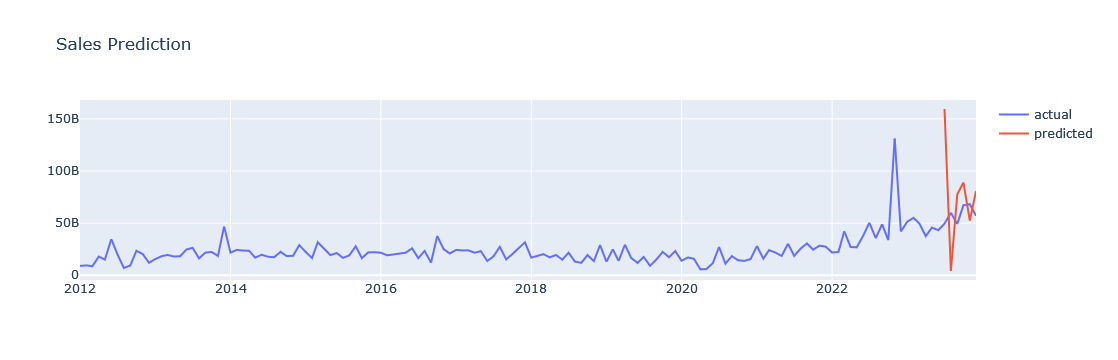

In [208]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(monthly_sum,df_result,on='date',how='left')#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['actual_worth'],
        name='actual'),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )]
plot_layout = go.Layout(
        title='Sales Prediction')
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)